### ** PROJECT 1: Automaitc Land Finding**
***

My first Jupyter Notebook. Hopefully it would go well

#### Goal:
    1. Apply Canny Transformation, Hough Transformation to extract lane lines in a given frame (or image)
    2. Familiar myself with OpenCV and numpy operation.
    3. Believe that I can be a self-driving engineer :D [ I used to attempt to work on self-driving car projects many times but I always failed because I did not have a mentor nor lacked of knowledge.


In [1]:
import cv2
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import math
from scipy import stats

# Import everything needed to edit/save/watch video clips
import moviepy
from moviepy.editor import VideoFileClip
from IPython.display import HTML

%matplotlib inline

** My PipeLine/Algorithm **

Global Variables:

* previous_left_right_slopes = []

* previous_polygon_vertices  = []


For every frame in a video:
    * Filtering image using Adaptive Equalization and HSV color space to extract white and yellow
    1. Apply Canny Edge and Hough Transform         
    3. Mask Region of Intrest         
    3. For each line segments:
        a. Calculate the slope K and weight (length of the line). Longer the length,more influence on avg. slope
            if (slope > 0): 
                add to right_slopes 
                compare to Max_point (highest ponint) and Min_point (lowest_point).
            if (slope < 0): 
                add to left_slopes
                compare to Max_point and Min_point.
    4. Calcualte Median left and right slopes relatively to previous slope
    5. Extrapolate max points using median slope and bottom points
---
**Structure of My Code***
1. process_video(): my pipeline is in here
2. get_line() and other helper methods definition
3. Example using 1 image
4. Example using 1 video
        

## ** Here are some of helper functions for the main pipeline**


In [20]:
prev_slope = [0, 0]
prev_int   = [0, 0]
alpha = 0.005        # To slow the change of slope during each frame
beta = 0.7           # To slow the change of y-intercept during each frame

## ** Main Pipeline **
def process_image(frame):
    # NOTE: The output you return should be a color image (3 channel) for processing video below
    # TODO: put your pipeline here,
    # you should return the final output (image with lines are drawn on lanes)
    global prev_slope
    global prev_line
    global beta
    im_shape = frame.shape
    xsize = im_shape[0]
    ysize = im_shape[1]

    # Points of polygon
    left_top = (ysize * 0.46, xsize * 0.50)
    left_bottom = (0+ysize*0.01, xsize)
    right_top = (ysize * 0.52, xsize * 0.50)
    right_bottom = (ysize, xsize)
    
    vertices = np.array([[left_top, right_top, right_bottom, left_bottom]], dtype=np.int32)

    # Initial points
    upper_left = [ysize, xsize]
    lower_left = [0, 0]
    upper_right = [ysize * 0.52, xsize * 0.5]
    lower_right = [0, xsize * 0.5]
    
    point_type = [(('x', int),('y',int)]
    right_points = []
    left_points = []

    #Initial slopes
    right_slopes = []
    left_slopes = []

    # HSV improvement
    hsv = hsv_image(frame)
    
    # Apply Canny Edge Detection
    canny = edge_detector(hsv, 3, 50, 150)
    
    # Mask a Region Of Interest
    edges = region_of_interest(canny, vertices)

    # color_edges = np.dstack((edges, edges, edges))
    color_edges = np.dstack((canny, canny, canny))

    # Hough Transform
    h_lines = find_hough_lines(edges, 13, 10, 80)

    for line in h_lines:
        slope = calculate_slope(line)
        if slope > 0:
            w = cal_slope_weight(line)
            right_slopes.append([slope, w])
            for x1, y1, x2,y2 in line:
                right_points.append((x1, y1))
                left_points.append((x2, y2))
            #[upper_right,lower_right] = update_boundary(line, upper_right,lower_right)
        if slope < 0:
            w = cal_slope_weight(line)
            left_slopes.append([slope, w])
            for x1, y1, x2,y2 in line:
                left_points.append((x1, y1))
                left_points.append((x2, y2))
            [upper_left, lower_left] = update_boundary(line, upper_left, lower_left)

            
    # Find max-min points
    points = np.array(right_points,dtype='point_type')
    upper_right = np.sort(points,order='y')[0]
    lower_right = np.sort(points,order='y')[len(points)]
    # Calculate Lines
    right_slope = avg_slope(right_slopes)
    left_slope = avg_slope(left_slopes)
    
    # print(lower_left, lower_right, frame.shape)
    # Avoid NaN or Infinity cases
    if np.isinf(right_slope) or np.isinf(left_slope):
        right_slope = prev_slope[0]
        left_slope = prev_slope[1]
        
    if (prev_slope[0] != 0 or prev_slope[1] != 0):
        right_slope = alpha*right_slope +(1-alpha)*prev_slope[0]
        left_slope  = alpha*left_slope +(1-alpha)*prev_slope[1]
    
    prev_slope = [right_slope, left_slope]
    
    # To avoid float infinity 
    upper_y = np.maximum(upper_left[1],upper_right[1])
    if prev_int[0] == 0 or prev_int[0] == 0:
        beta = 1
        
    # Determine y = mx +b
    right_line, prev_int[0] = get_line(right_slope, right_points, upper_y, xsize, lower_right, prev_int[0], beta)
    left_line,  prev_int[1] = get_line(left_slope,  left_points,  upper_y, xsize, lower_left,  prev_int[1], beta)
    
    line_image = draw_line_segments(np.copy(image)*0, [left_line], [255, 0, 0], 5)
    line_image = draw_line_segments(line_image,  [right_line], [255, 0, 0], 5)
    
    line_image =cv2.circle(line_image,(lower_left[0],lower_left[1]), 5,[255,255,0],5)
    line_image =cv2.circle(line_image,(upper_left[0],upper_left[1]), 5,[255,0,255],5)
    line_image =cv2.circle(line_image,(int(upper_right[0]),int(upper_right[1])), 9,[255,255,0],5)
    line_image =cv2.circle(line_image,(lower_right[0],lower_right[1]), 5,[255,255,0],5)
    print(upper_right,lower_right)
    
    #print(left_line)
    line_image = region_of_interest(line_image,vertices)
    result = weighted_img(frame, line_image)
    return  result


def get_line(slope, points, upper_y, yaxis, btm_point, prev_int, alpha):
    """
    """
    if len(points) > 0:

         # Find y-intercept
        intercept = btm_point[1] - slope*btm_point[0]
        
        #intercept = alpha*intercept + (1-alpha)*prev_int
        
        # Calculate upper_x
        upper_x = (upper_y - intercept)/slope
        # Calculate X_min
        lower_x = yaxis - intercept
        lower_x = lower_x/slope        
        upper_x = int(upper_x)
        lower_x = int(lower_x)
        
#         if math.isinf(upper_y):
#             upper_y = int(yaxis*0.5)
    
        line = np.array([[upper_x, int(upper_y), lower_x, int(yaxis)]])       
        return line, intercept
    
    else:
        return np.array([[0,0,0,0]]), prev_int
    
    
def draw_line_segments(source_image, h_lines, color=[255, 0, 0], thickness=2):
    """
    Draw the line segments to the source images.
    """

    line_img = np.copy(source_image)

    for a_line in h_lines:
        for x1, y1, x2, y2 in a_line:
            cv2.line(line_img, (x1, y1), (x2, y2), color, thickness)
    return line_img


In [17]:
def edge_detector(gray_img, gaussian_kernel_size=1, low_threshold=0, high_threshold=10):
    """
    Return possible edges in an image using Canny Transformation
    :param gray_img:             a grayed image
    :param gaussian_kernel_size: a kernel size for gaussian blur [default is 0]
    :param low_threshold:        default is 0
    :param high_threshold:       default is 10
    :return: edges in an image
    """
    
    # Apply gaussian blur  
    kernel_size = (gaussian_kernel_size, gaussian_kernel_size)
    blurred_image = cv2.GaussianBlur(gray_img, kernel_size, 0)

    # Canny Edge Detection
    canny_edges = cv2.Canny(blurred_image, low_threshold, high_threshold)
    return canny_edges


def find_hough_lines(edge_img, min_votes, min_length, max_gap):
    """
    Return a list of possible Hough Lines in edge_img
    
    :param edge_img:    a canny edge image
    :param min_votes:   a minimum threshold [votes] to be considered a possible line
    :param min_length:  a minimum length to be considered a line
    :param max_gap:     maximum gap between points that have the same line
    :return:            a list of possible lines
    
    Notice : a line in openCV contains : 2 vertices (x1,y1) and (x2,y2)
    """
    
    rho = 1             # perpendicular distance from origin to a line
    theta = np.pi/180   # angle between line and x-axis
    
    # Hough Transform Built-in function of OpenCV. Return a line segments in image
    lines = cv2.HoughLinesP(edge_img, rho, theta, min_votes, np.array([]), min_length, max_gap)
    return lines



def region_of_interest(img, vertices):
    """
    Filter out not-so-important region in the image
    :param source_img:
    :param vertices:    list of vertices to create a polygon
    :return:
    """
    mask = np.zeros_like(img)
    ignore_mask_color = 255
    
     #defining a 3 channel or 1 channel color to fill the mask with depending on the input image
    if len(img.shape) > 2:
        channel_count = img.shape[2]  # i.e. 3 or 4 depending on your image
        ignore_mask_color = (255,) * channel_count
    else:
        ignore_mask_color = 255
        
    cv2.fillPoly(mask, vertices, ignore_mask_color)
    
    masked_edges = cv2.bitwise_and(img, mask)
    return masked_edges


def adaptive_equalize_image(img, level):
    """
    Equalize an image - Increase contrast for the image
        # http://docs.opencv.org/3.1.0/d5/daf/tutorial_py_histogram_equalization.html
        
    :param img:    an gray image
    :param level:  clipLevel
    :return: a equalized image
    """
    clahe = cv2.createCLAHE(clipLimit=level)
    result = clahe.apply(img)
    return result

### ** Helper functions **

In [4]:
def gray_image(img):
    """
    Convert color image into gray scale image
    :param img: a color image
    :return: a gray image
    """
    return cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)

def hsv_image(img):
    """
    Convert BGR to HSV
    green = np.uint8([[[255,236,107]]])
    hsv_green = cv2.cvtColor(green,cv2.COLOR_BGR2HSV)
    print(hsv_green)
    """
    
    # Conver BGR to LAB
    lab = cv2.cvtColor(img, cv2.COLOR_BGR2LAB)
    l, a, b = cv2.split(lab)
    cl = adaptive_equalize_image(l, 3.0)
    merge = cv2.merge((cl, a, b))
    equalized = cv2.cvtColor(merge, cv2.COLOR_LAB2BGR)
    
    # Convert to HSV image
    hsv = cv2.cvtColor(equalized, cv2.COLOR_BGR2HSV)

    WHITE_MIN = np.array((0,0, 210))
    WHITE_MAX = np.array((140,20,255))
    YELLOW_MIN = np.array((89 ,40, 160))
    YELLOW_MAX= np.array((100, 200, 255))

    white_mask = cv2.inRange(hsv,WHITE_MIN, WHITE_MAX)
    yellow_mask = cv2.inRange(hsv, YELLOW_MIN, YELLOW_MAX)
    mask = cv2.addWeighted(white_mask,1.0,yellow_mask,1.0,0.0)
    hsv = cv2.bitwise_and(img, img, mask= mask)
    return hsv
    

def calculate_slope(line):
    """
    Calculate a slope of a line segment
    :param line:
    :return: slope value
    """
    slope = 0
    for x1, y1, x2, y2 in line:
        slope = (y1 - y2)/(x1 - x2)
    return slope


def update_boundary(line_segment, curr_top, curr_btm):
    """
    Update max point and min point of the line
    """
    for x1, y1, x2, y2 in line_segment:
        if  y1 < curr_top[1]:
            curr_top = [x1, y1]     
        elif y1 > curr_btm[1]:
            curr_btm = [x1, y1]
            
        if  y2 < curr_top[1]:
            curr_top = [x2, y2]       
        elif y2 > curr_btm[1]:
            curr_btm = [x2, y2]
    
    return [curr_top, curr_btm]
    
def cal_slope_weight(line):
    for x1,y1, x2, y2 in line:
        distance = math.pow(((x1-x2)**2 + (y1-y2)**2),1)
    return distance   

def avg_slope(slopes):
    """
    calculate avg slope based on the length of the edge (weight). 
    The longer edge, the more it affects the avg slope
    """
    slope = np.transpose(slopes)[0]
    weight = np.transpose(slopes)[1]
    
    mul_sw = np.sum(np.multiply(slope,weight))
    sum_w  = np.sum(weight)
    
    avg_slope = mul_sw/sum_w
    
    return avg_slope

def smooth_slope(new, prev, alpha):
    return alpha*new +(1-alpha)*prev
    
    
def weighted_img(img, initial_img, α=0.8, β=1., λ=0.):
    """
    `img` is the output of the hough_lines(), An image with lines drawn on it.
    Should be a blank image (all black) with lines drawn on it.
    
    `initial_img` should be the image before any processing.
    
    The result image is computed as follows:
    
    initial_img * α + img * β + λ
    NOTE: initial_img and img must be the same shape!
    """
    return cv2.addWeighted(initial_img, α, img, β, λ)



In [5]:
image = mpimg.imread('./test_images/whiteCarLaneSwitch.jpg')
# image = (mpimg.imread('challenge2.png')*255).astype('uint8')
#plt.imshow(image)
print('This image is:', type(image), 'with dimensions:', image.shape)

This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)


### ** Initialize polygon vertices and slopes **

In [6]:
im_shape = image.shape
xsize = im_shape[0]
ysize = im_shape[1]

# Points of polygon
left_top = (ysize * 0.46, xsize * 0.60)
left_bottom = (0+ysize*0.12, xsize)

right_top = (ysize * 0.52, xsize * 0.60)
right_bottom = (ysize - ysize*0.07, xsize)
vertices = np.array([[left_top, right_top, right_bottom, left_bottom]], dtype=np.int32)

# Initial points
upper_left = [ysize, xsize]
lower_left = [0, 0]

upper_right = [ysize * 0.52, xsize * 0.5]
lower_right = [0, xsize * 0.5]

right_points = []
left_points = []

#Initial slopes
right_slopes = []
left_slopes = []

# print(xsize, ysize)


In [7]:
# HSV improvement
hsv = hsv_image(image)

# Apply Canny Edge Detection
canny = edge_detector(hsv, 5, 50, 150)

# Mask a Region Of Interest 
edges = region_of_interest(canny, vertices)

# Hough Transform
h_lines = find_hough_lines(edges, 13, 10, 90)

color_edges = np.dstack((canny, canny, canny)) 
test = draw_line_segments(color_edges,h_lines,[255,0,0],2)


In [8]:
for line in h_lines:
    slope = calculate_slope(line)
    if slope > 0:
        w = cal_slope_weight(line)
        right_slopes.append([slope, w])
        for x1, y1, x2,y2 in line:
            right_points.append((x1, y1))
            right_points.append((x2, y2))
        [upper_right,lower_right] = update_boundary(line, upper_right,lower_right)
    if slope < 0:
        w = cal_slope_weight(line)
        left_slopes.append([slope, w])
        for x1, y1, x2,y2 in line:
            left_points.append((x1, y1))
            left_points.append((x2, y2))
        [upper_left, lower_left] = update_boundary(line, upper_left, lower_left)

print(upper_left, lower_left)
print(upper_right, lower_right)

[461, 327] [175, 539]
[499.20000000000005, 270.0] [882, 539]


In [9]:
# Calculate Lines
right_slope = avg_slope(right_slopes)
left_slope = avg_slope(left_slopes)

# right_slope = np.median(np.transpose(right_slopes)[0])
# left_slope = np.median(np.transpose(left_slopes)[0])
print(right_slope, left_slope)



0.566428951997 -0.788484090096


In [10]:
# To avoid float infinity 
upper_y = np.maximum(upper_left[1],upper_right[1])
temp = 0
temp1 =0
left_line, temp   = get_line(left_slope,  left_points, upper_y, xsize, lower_left, 0,1 )
right_line, temp1 = get_line(right_slope, right_points, upper_y, xsize, lower_right,0,1 )
print(temp, temp1)
line_image = draw_line_segments(np.copy(image)*0, [left_line], [255,0,0], 20)
line_image = draw_line_segments(line_image,  [right_line], [255, 0, 0], 20)

#plt.imshow(line_image)
line_image = region_of_interest(line_image,vertices)
result = weighted_img(image, line_image)
print(left_line, right_line)


676.984715767 39.4096643389
[[443 327 173 540]] [[507 327 883 540]]


Original Image: 
Canny Edge and Hough Transform:
Result:


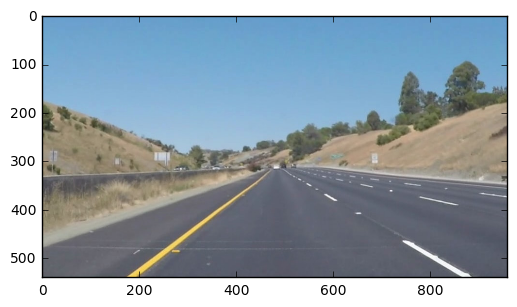

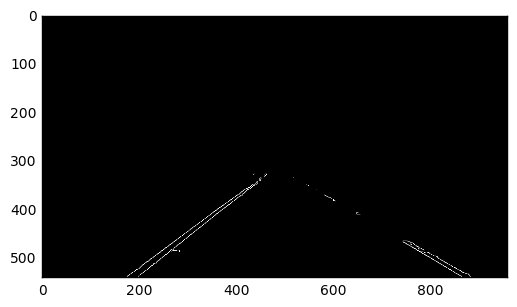

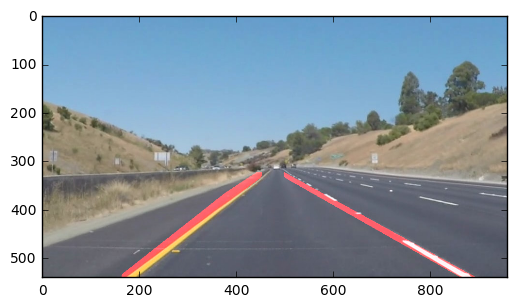

In [11]:
# Display all line

plt.figure(1)
print("Original Image: ")
plt.imshow(image)

plt.figure(2)
print("Canny Edge and Hough Transform:")
plt.imshow(edges, cmap='gray')

plt.figure(3)
print("Result:")
plt.imshow(result)

### Now Working on The Video
    

In [21]:
white_output = 'white.mp4'
clip1 = VideoFileClip("solidWhiteRight.mp4")
white_clip = clip1.fl_image(process_image)   # NOTE: this function expects color images!!
white_clip.write_videofile(white_output, audio=False)


TypeError: data type "point_type" not understood